## Compare 3 resolution: 1/4-deg vs 1/10-deg vs 1/12-deg (linear & nonlinear)

In [1]:
%matplotlib inline
import numpy as np
import xesmf as xe
import xarray as xr
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.interpolate import make_interp_spline
from scipy.interpolate import PchipInterpolator
import warnings
warnings.filterwarnings('ignore')

In [2]:
def global_mean_KE_snap(file,itime,fac_lat,fac_dep,area,rho_0=1035.0):
    data   = xr.open_dataset(file)
    height = data['e'].isel({'time':itime,'zi':0}) - data['e'].isel({'time':itime,'zi':1})
    KE     = data['KE'].isel({'time':itime,'zl':0}) *rho_0 *area *height *fac_dep *fac_lat
    mKE    = KE.sum(dim=["yh","xh"],skipna=True).values
    return mKE

In [3]:
def global_mean_APE_snap(file,itime,fac_lat,fac_dep,area,rho_0=1035.0):
    data = xr.open_dataset(file)
    ssh  = data['e'].isel({'time':itime,'zi':0})
    APE  = 0.5 *rho_0 *9.8 *ssh**2 *area *fac_dep *fac_lat
    mAPE = APE.sum(dim=["yh","xh"],skipna=True).values
    return mAPE

In [4]:
def get_KE_APE(exp_name, fac_lat, fac_dep, area):
    file = '/scratch/nm03/lxy581/mom6/archive/%s/output002/ocean_interior.nc'%exp_name
    print(file)
    SAH  = xr.open_dataset(file)
    mKE  = np.full((m2_period),np.nan)
    mAPE = np.full((m2_period),np.nan)
    for it in np.arange(m2_period):
        mKE[it]  = global_mean_KE_snap(file,it,fac_lat,fac_dep,area)
        mAPE[it] = global_mean_APE_snap(file,it,fac_lat,fac_dep,area)

    # Globally integrated time-mean KE (unit: J)
    mKE_SAH  = np.nanmean(mKE)
    # Globally integrated time-mean APE (unit: J)
    mAPE_SAH = np.nanmean(mAPE)
   
    return mKE_SAH, mAPE_SAH

In [5]:
rho_0 = 1035.0
m2_period = 236

In [6]:
file_stat = '/scratch/nm03/lxy581/mom6/archive/tides_025_global_sigma_01/output002/ocean_static.nc'
stat  = xr.open_dataset(file_stat)
depth_025  = stat['deptho']
geolat_025 = stat['geolat']
geolon_025 = stat['geolon']
area_025 = stat['areacello']
fac_dep_025 = xr.where(depth_025 > 1000, 1, np.nan) 
fac_lat_025 = xr.where((geolat_025 < 75) & (geolat_025 > -75), 1, np.nan)
fac_025 = np.array(fac_dep_025) * np.array(fac_lat_025)

In [7]:
file_stat = '/scratch/nm03/lxy581/mom6/archive/tides_008_global_sigma_01/output002/ocean_static.nc'
stat  = xr.open_dataset(file_stat)
depth_008  = stat['deptho']
geolat_008 = stat['geolat']
geolon_008 = stat['geolon']
area_008 = stat['areacello']
fac_dep_008 = xr.where(depth_008 > 1000, 1, np.nan) 
fac_lat_008 = xr.where((geolat_008 < 75) & (geolat_008 > -75), 1, np.nan)
fac_008 = np.array(fac_dep_008) * np.array(fac_lat_008)

In [8]:
file_stat = '/scratch/nm03/lxy581/mom6/archive/tides_01_global_sigma_01/output002/ocean_static.nc'
stat  = xr.open_dataset(file_stat)
yh, xh = stat.yh, stat.xh
depth_01  = stat['deptho']
geolat_01 = stat['geolat']
geolon_01 = stat['geolon']
area_01 = stat['areacello']
fac_dep_01 = xr.where(depth_01 > 1000, 1, np.nan) 
fac_lat_01 = xr.where((geolat_01 < 75) & (geolat_01 > -75), 1, np.nan)
fac_01 = np.array(fac_dep_01) * np.array(fac_lat_01)

In [9]:
tpxo = xr.open_dataset('/g/data/nm03/TPXO/h_tpxo9.v1.nc')
tpgd = xr.open_dataset('/g/data/nm03/TPXO/grid_tpxo9.nc')
pha_tpxo = (tpxo.hp.isel({'nc':0}).transpose()-180) /180 *np.pi +13*np.pi/16
amp_tpxo = tpxo.ha.isel({'nc':0}).transpose()
lon_tpxo = tpgd.lon_z.transpose()
lat_tpxo = tpgd.lat_z.transpose()
hz_tpxo  = tpgd.hz.transpose()
ny, nx   = tpgd.ny, tpgd.nx

In [10]:
ds_tpxo_data = xr.Dataset(data_vars={'pha_tpxo': (('ny','nx'), np.array(pha_tpxo)),
                                     'amp_tpxo': (('ny','nx'), np.array(amp_tpxo)),
                                     'hz_tpxo': (('ny','nx'), np.array(hz_tpxo))},
                          coords={'lon': (('ny', 'nx'), np.array(lon_tpxo)), 
                                  'lat': (('ny', 'nx'), np.array(lat_tpxo))})
ds_mom6_grid = xr.Dataset({"lat": (["yh","xh"], np.array(geolat_01)),
                           "lon": (["yh","xh"], np.array(geolon_01))})
regridder = xe.Regridder(ds_tpxo_data, ds_mom6_grid, "bilinear", extrap_method="inverse_dist")
ds_tpxo_mom6_grid = regridder(ds_tpxo_data)

--------------------------------------------------------------------------

  Local host:   gadi-cpu-bdw-0005
  Local device: mlx5_0
--------------------------------------------------------------------------


In [39]:
mKE_025 = np.full((17),np.nan)
mAPE_025 = np.full((17),np.nan)
mKE_01 = np.full((17),np.nan)
mAPE_01 = np.full((17),np.nan)
mKE_008 = np.full((17),np.nan)
mAPE_008 = np.full((17),np.nan)
# nonlinear 
mKE_008_non = np.full((3),np.nan)
mAPE_008_non = np.full((3),np.nan)

In [64]:
for j in range(17):
    with open('/g/data/nm03/lxy581/evaluate/amp_phase/tides_025_global_sigma_%02d.txt'%j, 'r') as file:
        lines_025 = file.readlines()
    # Split the line into separate numbers and convert them to integers
    mKE_025[j], mAPE_025[j] = float(lines_025[0].strip()), float(lines_025[1].strip())

    with open('/g/data/nm03/lxy581/evaluate/amp_phase/tides_01_global_sigma_%02d.txt'%j, 'r') as file:
        lines_01 = file.readlines()
    # Split the line into separate numbers and convert them to integers
    mKE_01[j], mAPE_01[j] = float(lines_01[0].strip()), float(lines_01[1].strip())

    with open('/g/data/nm03/lxy581/evaluate/amp_phase/tides_008_global_sigma_%02d.txt'%j, 'r') as file:
        lines_008 = file.readlines()
    # Split the line into separate numbers and convert them to integers
    mKE_008[j], mAPE_008[j] = float(lines_008[0].strip()), float(lines_008[1].strip())

In [43]:
for j in range(3):
    with open('/g/data/nm03/lxy581/evaluate/amp_phase/tides_008_global_sigma_nonlinear_x%02d.txt'%((j+2)*3), 'r') as file:
        lines_008_non = file.readlines()
    # Split the line into separate numbers and convert them to integers
    mKE_008_non[j], mAPE_008_non[j] = float(lines_008_non[0].strip()), float(lines_008_non[1].strip())

In [13]:
tpxo_vel = xr.open_dataset('/g/data/nm03/TPXO/u_tpxo9.v1.nc')
ua_tpxo = tpxo_vel.ua.isel({'nc':0}).transpose()/100
va_tpxo = tpxo_vel.va.isel({'nc':0}).transpose()/100
up_tpxo = (tpxo_vel.up.isel({'nc':0}).transpose() - 180) /180 *np.pi +13*np.pi/16
vp_tpxo = (tpxo_vel.vp.isel({'nc':0}).transpose() - 180) /180 *np.pi +13*np.pi/16
lon_u_tpxo = tpxo_vel.lon_u.transpose()
lat_u_tpxo = tpxo_vel.lat_u.transpose()
lon_v_tpxo = tpxo_vel.lon_v.transpose()
lat_v_tpxo = tpxo_vel.lat_v.transpose()

In [14]:
# ds_tpxo_u_nd = xr.Dataset(data_vars={'ua_tpxo': (('ny','nx'), np.array(ua_tpxo)),
#                                      'up_tpxo': (('ny','nx'), np.array(up_tpxo))},
#                           coords={'lon': (('ny', 'nx'), np.array(lon_u_tpxo)), 
#                                   'lat': (('ny', 'nx'), np.array(lat_u_tpxo))})
# ds_tpxo_v_nd = xr.Dataset(data_vars={'va_tpxo': (('ny','nx'), np.array(va_tpxo)),
#                                      'vp_tpxo': (('ny','nx'), np.array(vp_tpxo))},
#                           coords={'lon': (('ny', 'nx'), np.array(lon_v_tpxo)), 
#                                   'lat': (('ny', 'nx'), np.array(lat_v_tpxo))})
# ds_mom6_grid = xr.Dataset({"lat": (["yh","xh"], np.array(geolat_01)),
#                            "lon": (["yh","xh"], np.array(geolon_01))})
# regridder_ua = xe.Regridder(ds_tpxo_u_nd, ds_mom6_grid, "bilinear", extrap_method="inverse_dist")
# regridder_va = xe.Regridder(ds_tpxo_v_nd, ds_mom6_grid, "bilinear", extrap_method="inverse_dist")
# ds_ua_mom6_grid = regridder_ua(ds_tpxo_u_nd)
# ds_va_mom6_grid = regridder_va(ds_tpxo_v_nd)

### TPXO globally integrated time-mean KE

In [15]:
# t_12cyc = np.arange(m2_period)
# nt_tpxo = t_12cyc.size
# omega_m2 = np.full((nt_tpxo,yh.size,xh.size),(2*np.pi/(12.4206014)))
# days = np.array([0,31,28,31,30,31,30,31,31,30,31,30,31,31,28,31,30,31,30,31,31,30,31,30,31])
# days_accum = np.cumsum(days)
# u_tpxo = np.array(ds_ua_mom6_grid['ua_tpxo'])[None,:,:] * np.cos(omega_m2 * (t_12cyc[:,None,None]+days_accum[2]*24) - np.array(ds_ua_mom6_grid['up_tpxo'])[None,:,:])
# v_tpxo = np.array(ds_va_mom6_grid['va_tpxo'])[None,:,:] * np.cos(omega_m2 * (t_12cyc[:,None,None]+days_accum[2]*24) - np.array(ds_va_mom6_grid['vp_tpxo'])[None,:,:])

In [16]:
# elev_tpxo = np.array(ds_tpxo_mom6_grid['amp_tpxo'])[None,:,:] * np.cos(omega_m2 * (t_12cyc[:,None,None]+days_accum[2]*24) - np.array(ds_tpxo_mom6_grid['pha_tpxo'])[None,:,:])
# KE_TPXO = 0.5 *rho_0 *(u_tpxo **2 + v_tpxo **2) * (elev_tpxo + np.array(ds_tpxo_mom6_grid['hz_tpxo'])[None,:,:]) * np.array(area)[None,:,:] *np.array(fac_lat)[None,:,:] *np.array(fac_dep)[None,:,:]

In [17]:
# mKE_TPXO = np.nansum(np.nanmean(KE_TPXO,axis=0))
# print(mKE_TPXO)

In [18]:
mKE_TPXO = 1.4187602488006986e+17
mAPE_TPXO = 1.121135711180522e+17

### TPXO globally integrated time-mean APE

In [19]:
# APE_TPXO = 0.5 *rho_0 *9.8 * elev_tpxo**2 * np.array(area)[None,:,:] *np.array(fac_lat)[None,:,:] *np.array(fac_dep)[None,:,:]

In [20]:
# mAPE_TPXO = np.nansum(np.nanmean(APE_TPXO,axis=0))
# print(mAPE_TPXO)

In [51]:
fac = np.array([1,3,6,9,12,15,18,21,24,27,30,33,36,39,42,45,48])
RMSE_025 = np.full((17),np.nan)
RMSE_01  = np.full((17),np.nan)
RMSE_008 = np.full((17),np.nan)
RMSE_008_non = np.full((3),np.nan)

dissip_025 = np.full((17),np.nan)
dissip_01  = np.full((17),np.nan)
dissip_008 = np.full((17),np.nan)
dissip_008_non = np.full((3),np.nan)

perc_025 = np.full((17),np.nan)
perc_01  = np.full((17),np.nan)
perc_008 = np.full((17),np.nan)
perc_008_non = np.full((3),np.nan)

cdrag_025 = np.full((17),np.nan)
cdrag_01  = np.full((17),np.nan)
cdrag_008 = np.full((17),np.nan)
cdrag_008_non = np.full((3),np.nan)

sigma_025 = np.full((17),np.nan)
sigma_01  = np.full((17),np.nan)
sigma_008 = np.full((17),np.nan)
sigma_008_non = np.full((3),np.nan)

### Dissipation

In [52]:
for i in range(17):
    dir_sig = '/g/data/nm03/lxy581/evaluate/dissip/M2_dissip_025_sigma_%02d.nc'%i
    data = xr.open_dataset(dir_sig)
    
    global_cdrag = np.nansum(np.array(data.dissip_cdrag) * np.array(area_025)) / 1e+12
    global_sigma = np.nansum(np.array(data.dissip_sigma) * np.array(area_025)) / 1e+12

    cdrag_025[i] = global_cdrag
    sigma_025[i] = global_sigma
    
    dissip_025[i] = global_cdrag + global_sigma
    perc_025[i] = global_sigma/(global_cdrag + global_sigma)

In [53]:
for i in range(17):
    dir_sig = '/g/data/nm03/lxy581/evaluate/dissip/M2_dissip_008_sigma_%02d.nc'%i
    data = xr.open_dataset(dir_sig)
    
    global_cdrag = np.nansum(np.array(data.dissip_cdrag) * np.array(area_008)) / 1e+12
    global_sigma = np.nansum(np.array(data.dissip_sigma) * np.array(area_008)) / 1e+12

    cdrag_008[i] = global_cdrag
    sigma_008[i] = global_sigma
    
    dissip_008[i] = global_cdrag + global_sigma
    perc_008[i] = global_sigma/(global_cdrag + global_sigma)

In [54]:
for i in range(3):
    dir_sig = '/g/data/nm03/lxy581/evaluate/dissip/M2_dissip_008_sigma_nonlinear_x%02d.nc'%((i+2)*3)
    data = xr.open_dataset(dir_sig)
    
    global_cdrag = np.nansum(np.array(data.dissip_cdrag) * np.array(area_008)) / 1e+12
    global_sigma = np.nansum(np.array(data.dissip_sigma) * np.array(area_008)) / 1e+12

    cdrag_008_non[i] = global_cdrag
    sigma_008_non[i] = global_sigma
    
    dissip_008_non[i] = global_cdrag + global_sigma
    perc_008_non[i] = global_sigma/(global_cdrag + global_sigma)

In [55]:
for i in range(17):
    dir_sig = '/g/data/nm03/lxy581/evaluate/dissip/M2_dissip_01_sigma_%02d.nc'%i
    data = xr.open_dataset(dir_sig)
    
    global_cdrag = np.nansum(np.array(data.dissip_cdrag) * np.array(area_01)) / 1e+12
    global_sigma = np.nansum(np.array(data.dissip_sigma) * np.array(area_01)) / 1e+12

    cdrag_01[i] = global_cdrag
    sigma_01[i] = global_sigma

    dissip_01[i] = global_cdrag + global_sigma
    perc_01[i] = global_sigma/(global_cdrag + global_sigma)

In [56]:
for i in range(17):
    dir_sig = '/g/data/nm03/lxy581/evaluate/amp_phase/MOM6_025_SAH_M2_sigma_%02d_RMSE_total.nc'%i
    data = xr.open_dataset(dir_sig)
    RMSE_025[i] = np.sqrt(np.nansum(data.elev_err**2 * area_025)/np.nansum(area_025))*100

In [57]:
for i in range(17):
    dir_sig = '/g/data/nm03/lxy581/evaluate/amp_phase/MOM6_008_SAH_M2_sigma_%02d_RMSE_decomp.nc'%i
    data = xr.open_dataset(dir_sig)
    b = np.sqrt(np.nansum(data.ele_err_amp**2 * area_008)/np.nansum(area_008))*100
    c = np.sqrt(np.nansum(data.ele_err_pha**2 * area_008)/np.nansum(area_008))*100
    RMSE_008[i] = np.sqrt(b**2 + c**2)

In [58]:
for i in range(3):
    dir_sig = '/g/data/nm03/lxy581/evaluate/amp_phase/MOM6_008_SAH_M2_sigma_nonlinear_x%02d_RMSE_decomp.nc'%((i+2)*3)
    data = xr.open_dataset(dir_sig)
    b = np.sqrt(np.nansum(data.ele_err_amp**2 * area_008)/np.nansum(area_008))*100
    c = np.sqrt(np.nansum(data.ele_err_pha**2 * area_008)/np.nansum(area_008))*100
    RMSE_008_non[i] = np.sqrt(b**2 + c**2)

In [59]:
for i in range(17):
    dir_sig = '/g/data/nm03/lxy581/evaluate/amp_phase/MOM6_01_SAH_M2_sigma_%02d_RMSE_total.nc'%i
    data = xr.open_dataset(dir_sig)
    RMSE_01[i] = np.sqrt(np.nansum(data.elev_err**2 * area_01)/np.nansum(area_01))*100

In [67]:
print(np.nanmin(RMSE_025),np.nanmax(RMSE_025))
print(np.nanmin(RMSE_01),np.nanmax(RMSE_01))
print(np.nanmin(RMSE_008),np.nanmax(RMSE_008))
print(RMSE_008_non)
print(mKE_008_non)
print(mAPE_008_non)

7.03767389859879 14.719412429280036
6.725144046520573 13.196136913741244
6.92085780026327 13.268613541158084
[7.20504031 6.46672622 6.26289576]
[1.98427401e+17 1.73402348e+17 1.53980381e+17]
[1.55609601e+17 1.34605509e+17 1.18432231e+17]


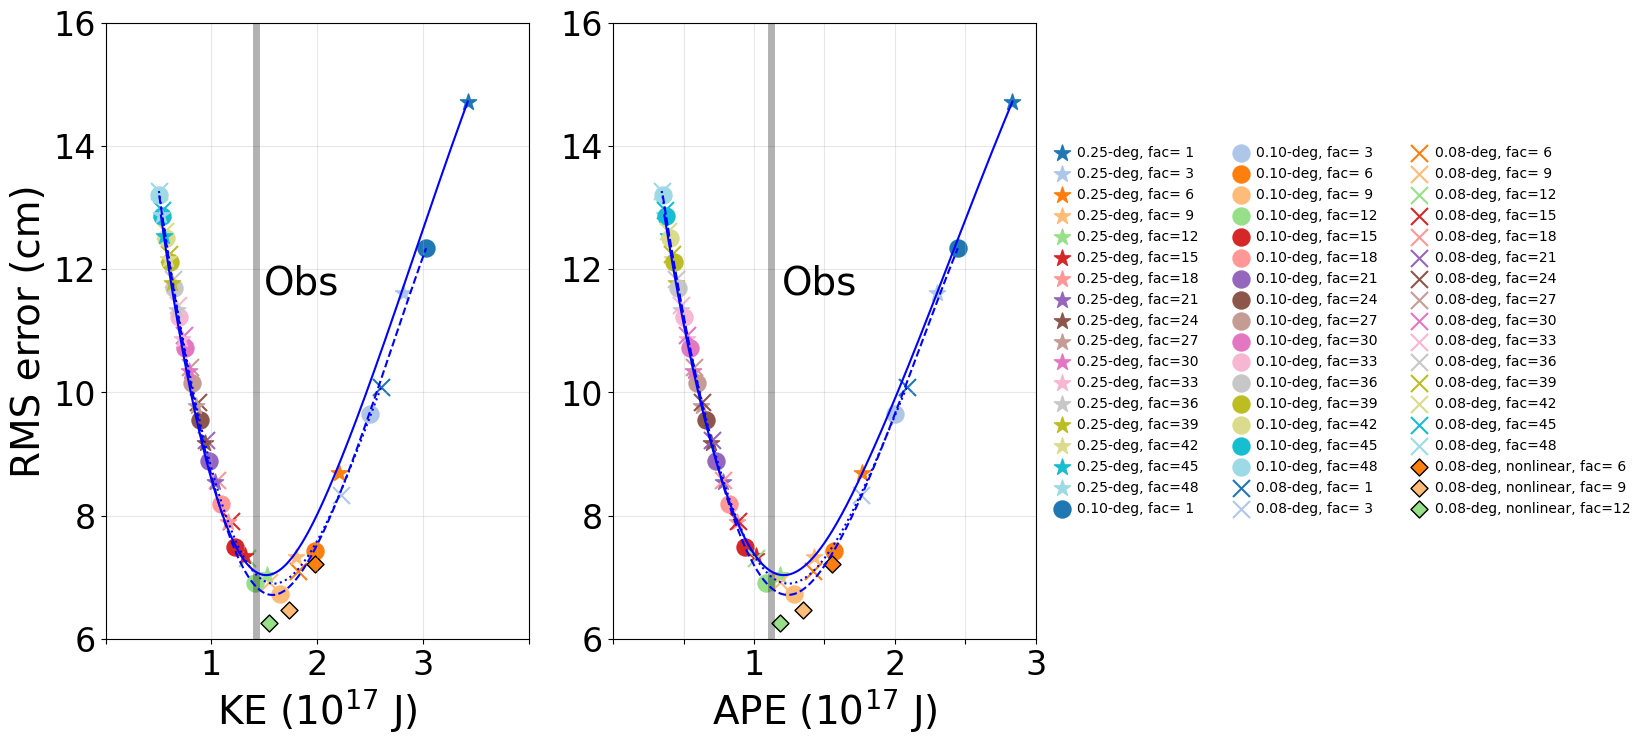

In [75]:
fig = plt.figure(figsize=(12, 8))
axs = []

gridsubs = gridspec.GridSpec(1,2)
for gs in gridsubs:
    axs.append(plt.subplot(gs))

# c_text = ['k','b','g','c','r','orange','m','purple']
colors = plt.cm.tab20(np.linspace(0, 1, 17))

def sort_interp(mKE, rmse, k=3):
    sorted_ind = np.argsort(mKE)
    mKE_sorted = mKE[sorted_ind]
    rmse_sorted = rmse[sorted_ind]
    
    mKE_smooth = np.linspace(mKE_sorted.min(), mKE_sorted.max(), 500)  # Create a smooth x-axis
    spline = make_interp_spline(mKE_sorted, rmse_sorted, k=3)         # Cubic spline interpolation
    # spline = PchipInterpolator(mKE_sorted, rmse_sorted)         # Cubic spline interpolation
    rmse_smooth = spline(mKE_smooth)
    
    return mKE_smooth, rmse_smooth

ke_smooth_025, rmse_smooth_025 = sort_interp(mKE_025, RMSE_025)
ke_smooth_01, rmse_smooth_01 = sort_interp(mKE_01, RMSE_01)
ke_smooth_008, rmse_smooth_008 = sort_interp(mKE_008, RMSE_008)

ape_smooth_025, rmse_smooth_025 = sort_interp(mAPE_025, RMSE_025)
ape_smooth_01, rmse_smooth_01 = sort_interp(mAPE_01, RMSE_01)
ape_smooth_008, rmse_smooth_008 = sort_interp(mAPE_008, RMSE_008)

for I, ax in enumerate(axs):
    
    ax.set_ylim(6,16)
    ax.set_yticks(np.arange(6,16+2,2))
    ax.tick_params(labelsize=24)

    marker_size = 150
    if I==0:
        ax.set_xlim(0e+17,4e+17)
        ax.set_xticks(np.arange(0e+17,5e+17,1e+17))
        ax.set_xticklabels(['','1','2','3',''])
        # ax.set_xlim(0.5e+17,3.5e+17)
        # ax.set_xticks(np.arange(0.5e+17,3.5e+17,0.5e+17))
        # ax.set_xticklabels(['','1','1.5','2','2.5','3'])
        ax.set_xlabel('KE (10$^{17}$ J)',fontsize=28)
        ax.set_ylabel('RMS error (cm)',fontsize=28)
        ax.text(1.5e+17,11.6,'Obs',fontsize=28)
        ax.plot([mKE_TPXO,mKE_TPXO],[6,18],'k',linewidth=5,alpha=0.3)
        ax.plot(ke_smooth_025, rmse_smooth_025, color='b')
        ax.plot(ke_smooth_01, rmse_smooth_01, color='b',linestyle='--')
        ax.plot(ke_smooth_008, rmse_smooth_008, color='b',linestyle=':')

        for i in range(17):
            ax.scatter(mKE_025[i],RMSE_025[i],s=marker_size,c=colors[i],marker='*',edgecolor=colors[i])
            ax.scatter(mKE_01[i],RMSE_01[i],s=marker_size,c=colors[i],marker='o',edgecolor=colors[i])
            ax.scatter(mKE_008[i],RMSE_008[i],s=marker_size,c=colors[i],marker='x',edgecolor=colors[i])
        for i in range(3):
            ax.scatter(mKE_008_non[i],RMSE_008_non[i],s=marker_size/2,c=colors[i+2],marker='D',edgecolor='k')

        ax.grid(True,alpha=0.3)

    if I==1:
        ax.set_xlim(0e+17,3e+17)
        ax.set_xticks(np.arange(0e+17,3.5e+17,0.5e+17))
        ax.set_xticklabels(['','','1','','2','','3'])
        ax.set_xlabel('APE (10$^{17}$ J)',fontsize=28)
        ax.text(1.2e+17,11.6,'Obs',fontsize=28)
        ax.plot([mAPE_TPXO,mAPE_TPXO],[6,18],'k',linewidth=5,alpha=0.3)
        ax.plot(ape_smooth_025, rmse_smooth_025, color='b')
        ax.plot(ape_smooth_01, rmse_smooth_01, color='b',linestyle='--')
        ax.plot(ape_smooth_008, rmse_smooth_008, color='b',linestyle=':')

        for i in range(17):
            ax.scatter(mAPE_025[i],RMSE_025[i],s=marker_size,c=colors[i],marker='*',edgecolor=colors[i],label='0.25-deg, fac=%2d'%fac[i])
        for i in range(17):
            ax.scatter(mAPE_01[i],RMSE_01[i],s=marker_size,c=colors[i],marker='o',edgecolor=colors[i],label='0.10-deg, fac=%2d'%fac[i])
        for i in range(17):
            ax.scatter(mAPE_008[i],RMSE_008[i],s=marker_size,c=colors[i],marker='x',edgecolor=colors[i],label='0.08-deg, fac=%2d'%fac[i])
        for i in range(3):
            ax.scatter(mAPE_008_non[i],RMSE_008_non[i],s=marker_size/2,c=colors[i+2],marker='D',edgecolor='k',label='0.08-deg, nonlinear, fac=%2d'%((i+2)*3))
        ax.grid(True,alpha=0.3)

        ax.legend(loc='center left',bbox_to_anchor=(1,0.5),fontsize=10,ncol=3,handletextpad=0.1,frameon=False)

plt.savefig('/g/data/nm03/lxy581/evaluate/tuning/SAL_SAH_masked_TPXO_M2_008_01_025_KE_APE_RMSE.png', dpi=600, bbox_inches='tight')

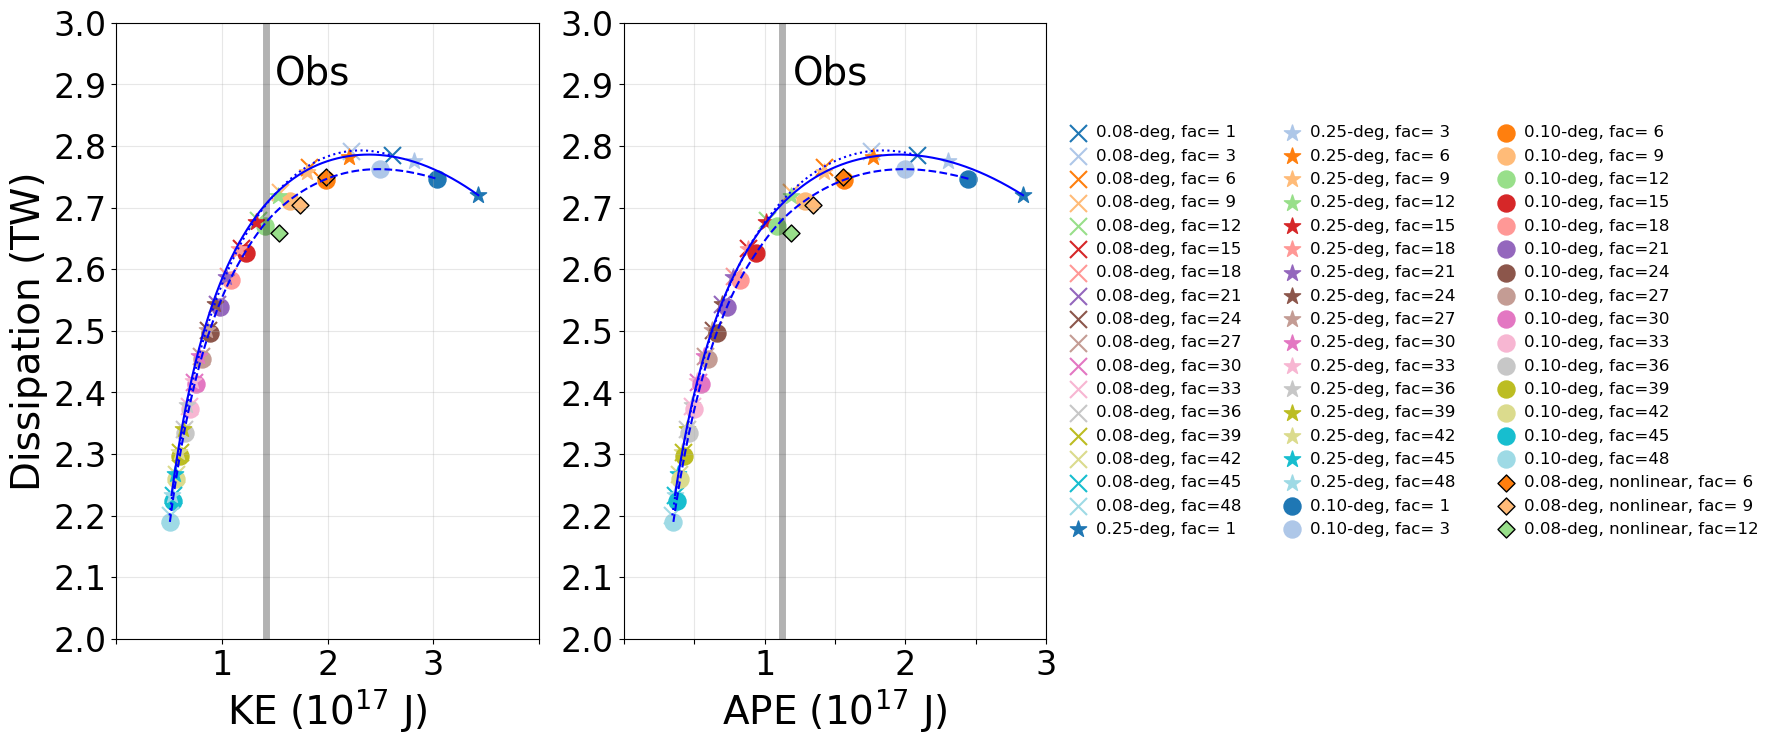

In [76]:
fig = plt.figure(figsize=(12, 8))
axs = []

gridsubs = gridspec.GridSpec(1,2)
for gs in gridsubs:
    axs.append(plt.subplot(gs))

# c_text = ['k','b','g','c','r','orange','m','purple']
colors = plt.cm.tab20(np.linspace(0, 1, 17))

def sort_interp(mKE, rmse, k=3):
    sorted_ind = np.argsort(mKE)
    mKE_sorted = mKE[sorted_ind]
    rmse_sorted = rmse[sorted_ind]
    
    mKE_smooth = np.linspace(mKE_sorted.min(), mKE_sorted.max(), 5000)  # Create a smooth x-axis
    spline = make_interp_spline(mKE_sorted, rmse_sorted, k=3)         # Cubic spline interpolation
    # spline = PchipInterpolator(mKE_sorted, rmse_sorted)         # Cubic spline interpolation
    rmse_smooth = spline(mKE_smooth)
    
    return mKE_smooth, rmse_smooth

ke_smooth_008, dissip_smooth_008 = sort_interp(mKE_008, dissip_008)
ke_smooth_025, dissip_smooth_025 = sort_interp(mKE_025, dissip_025)
ke_smooth_01, dissip_smooth_01 = sort_interp(mKE_01, dissip_01,k=2)

ape_smooth_008, dissip_smooth_008 = sort_interp(mAPE_008, dissip_008)
ape_smooth_025, dissip_smooth_025 = sort_interp(mAPE_025, dissip_025)
ape_smooth_01, dissip_smooth_01 = sort_interp(mAPE_01, dissip_01,k=2)

for I, ax in enumerate(axs):
    
    ax.set_ylim(2,3)
    ax.set_yticks(np.arange(2,3+0.1,0.1))
    ax.tick_params(labelsize=24)

    marker_size = 150
    if I==0:
        ax.set_xlim(0e+17,4e+17)
        ax.set_xticks(np.arange(0e+17,5e+17,1e+17))
        ax.set_xticklabels(['','1','2','3',''])
        # ax.set_xlim(0.5e+17,3.5e+17)
        # ax.set_xticks(np.arange(0.5e+17,3.5e+17,0.5e+17))
        # ax.set_xticklabels(['','1','1.5','2','2.5','3'])
        ax.set_xlabel('KE (10$^{17}$ J)',fontsize=28)
        ax.set_ylabel('Dissipation (TW)',fontsize=28)
        ax.text(1.5e+17,2.9,'Obs',fontsize=28)
        ax.plot([mKE_TPXO,mKE_TPXO],[0,3],'k',linewidth=5,alpha=0.3)
        ax.plot(ke_smooth_025, dissip_smooth_025, color='b')
        ax.plot(ke_smooth_01, dissip_smooth_01, color='b',linestyle='--')
        ax.plot(ke_smooth_008, dissip_smooth_008, color='b',linestyle=':')
        for i in range(17):
            ax.scatter(mKE_025[i],dissip_025[i],s=marker_size,c=colors[i],marker='*',edgecolor=colors[i])
            ax.scatter(mKE_01[i],dissip_01[i],s=marker_size,c=colors[i],marker='o',edgecolor=colors[i])
            ax.scatter(mKE_008[i],dissip_008[i],s=marker_size,c=colors[i],marker='x',edgecolor=colors[i])
        for i in range(3):
            ax.scatter(mKE_008_non[i],dissip_008_non[i],s=marker_size/2,c=colors[i+2],marker='D',edgecolor='k')
        ax.grid(True,alpha=0.3)

    if I==1:
        ax.set_xlim(0e+17,3e+17)
        ax.set_xticks(np.arange(0e+17,3.5e+17,0.5e+17))
        ax.set_xticklabels(['','','1','','2','','3'])
        ax.set_xlabel('APE (10$^{17}$ J)',fontsize=28)
        ax.text(1.2e+17,2.9,'Obs',fontsize=28)
        ax.plot([mAPE_TPXO,mAPE_TPXO],[0,3],'k',linewidth=5,alpha=0.3)
        ax.plot(ape_smooth_025, dissip_smooth_025, color='b')
        ax.plot(ape_smooth_01, dissip_smooth_01, color='b',linestyle='--')
        ax.plot(ape_smooth_008, dissip_smooth_008, color='b',linestyle=':')

        for i in range(17):
            ax.scatter(mAPE_008[i],dissip_008[i],s=marker_size,c=colors[i],marker='x',edgecolor=colors[i],label='0.08-deg, fac=%2d'%fac[i])
        for i in range(17):
            ax.scatter(mAPE_025[i],dissip_025[i],s=marker_size,c=colors[i],marker='*',edgecolor=colors[i],label='0.25-deg, fac=%2d'%fac[i])
        for i in range(17):
            ax.scatter(mAPE_01[i],dissip_01[i],s=marker_size,c=colors[i],marker='o',edgecolor=colors[i],label='0.10-deg, fac=%2d'%fac[i])
        for i in range(3):
            ax.scatter(mAPE_008_non[i],dissip_008_non[i],s=marker_size/2,c=colors[i+2],marker='D',edgecolor='k',label='0.08-deg, nonlinear, fac=%2d'%((i+2)*3))
        ax.grid(True,alpha=0.3)

        ax.legend(loc='center left',bbox_to_anchor=(1,0.5),fontsize=12,ncol=3,handletextpad=0.1,frameon=False)

plt.savefig('/g/data/nm03/lxy581/evaluate/tuning/SAL_SAH_masked_TPXO_M2_008_01_025_KE_APE_dissip.png', dpi=600, bbox_inches='tight')

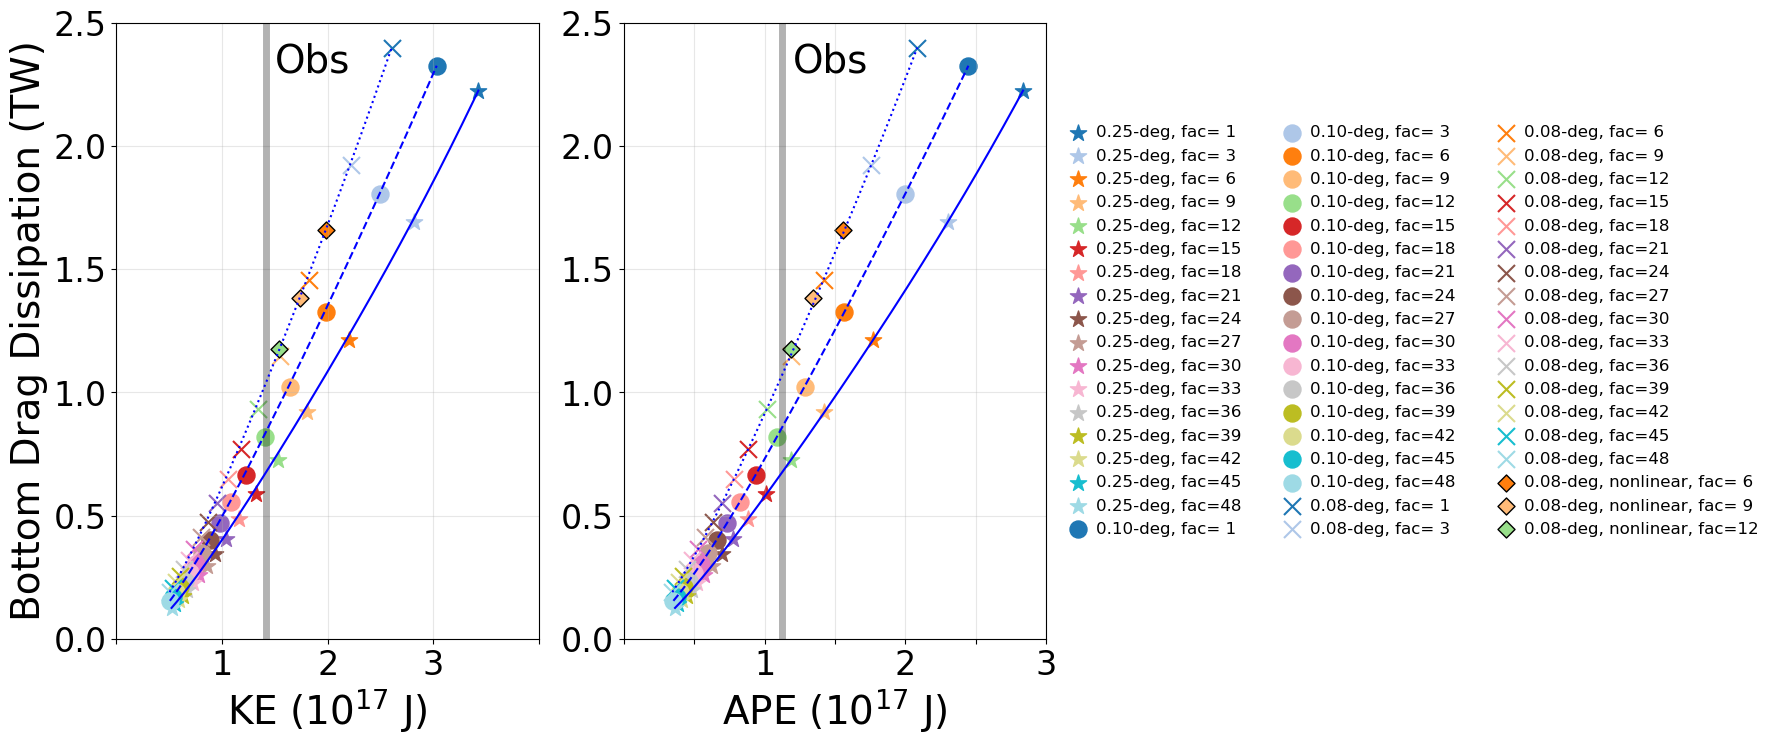

In [77]:
fig = plt.figure(figsize=(12, 8))
axs = []

gridsubs = gridspec.GridSpec(1,2)
for gs in gridsubs:
    axs.append(plt.subplot(gs))

# c_text = ['k','b','g','c','r','orange','m','purple']
colors = plt.cm.tab20(np.linspace(0, 1, 17))

def sort_interp(mKE, rmse, k=3):
    sorted_ind = np.argsort(mKE)
    mKE_sorted = mKE[sorted_ind]
    rmse_sorted = rmse[sorted_ind]
    
    mKE_smooth = np.linspace(mKE_sorted.min(), mKE_sorted.max(), 5000)  # Create a smooth x-axis
    spline = make_interp_spline(mKE_sorted, rmse_sorted, k=3)         # Cubic spline interpolation
    # spline = PchipInterpolator(mKE_sorted, rmse_sorted)         # Cubic spline interpolation
    rmse_smooth = spline(mKE_smooth)
    
    return mKE_smooth, rmse_smooth


ke_smooth_025, cdrag_smooth_025 = sort_interp(mKE_025, cdrag_025,k=2)
ke_smooth_01, cdrag_smooth_01 = sort_interp(mKE_01, cdrag_01,k=2)
ke_smooth_008, cdrag_smooth_008 = sort_interp(mKE_008, cdrag_008)

ape_smooth_025, cdrag_smooth_025 = sort_interp(mAPE_025, cdrag_025,k=2)
ape_smooth_01, cdrag_smooth_01 = sort_interp(mAPE_01, cdrag_01,k=2)
ape_smooth_008, cdrag_smooth_008 = sort_interp(mAPE_008, cdrag_008)

for I, ax in enumerate(axs):
    
    ax.set_ylim(0,2.5)
    ax.set_yticks(np.arange(0,2.5+0.5,0.5))
    ax.tick_params(labelsize=24)

    marker_size = 150
    if I==0:
        ax.set_xlim(0e+17,4e+17)
        ax.set_xticks(np.arange(0e+17,5e+17,1e+17))
        ax.set_xticklabels(['','1','2','3',''])
        ax.set_xlabel('KE (10$^{17}$ J)',fontsize=28)
        ax.set_ylabel('Bottom Drag Dissipation (TW)',fontsize=28)
        ax.text(1.5e+17,2.3,'Obs',fontsize=28)
        ax.plot([mKE_TPXO,mKE_TPXO],[0,3],'k',linewidth=5,alpha=0.3)
        ax.plot(ke_smooth_025, cdrag_smooth_025, color='b')
        ax.plot(ke_smooth_01, cdrag_smooth_01, color='b',linestyle='--')
        ax.plot(ke_smooth_008, cdrag_smooth_008, color='b',linestyle=':')

        for i in range(17):
            ax.scatter(mKE_025[i],cdrag_025[i],s=marker_size,c=colors[i],marker='*',edgecolor=colors[i])
            ax.scatter(mKE_01[i],cdrag_01[i],s=marker_size,c=colors[i],marker='o',edgecolor=colors[i])
            ax.scatter(mKE_008[i],cdrag_008[i],s=marker_size,c=colors[i],marker='x',edgecolor=colors[i])
        for i in range(3):
            ax.scatter(mKE_008_non[i],cdrag_008_non[i],s=marker_size/2,c=colors[i+2],marker='D',edgecolor='k')
        ax.grid(True,alpha=0.3)

    if I==1:
        ax.set_xlim(0e+17,3e+17)
        ax.set_xticks(np.arange(0e+17,3.5e+17,0.5e+17))
        ax.set_xticklabels(['','','1','','2','','3'])
        ax.set_xlabel('APE (10$^{17}$ J)',fontsize=28)
        ax.text(1.2e+17,2.3,'Obs',fontsize=28)
        ax.plot([mAPE_TPXO,mAPE_TPXO],[0,3],'k',linewidth=5,alpha=0.3)
        ax.plot(ape_smooth_025, cdrag_smooth_025, color='b')
        ax.plot(ape_smooth_01, cdrag_smooth_01, color='b',linestyle='--')
        ax.plot(ape_smooth_008, cdrag_smooth_008, color='b',linestyle=':')

        for i in range(17):
            ax.scatter(mAPE_025[i],cdrag_025[i],s=marker_size,c=colors[i],marker='*',edgecolor=colors[i],label='0.25-deg, fac=%2d'%fac[i])
        for i in range(17):
            ax.scatter(mAPE_01[i],cdrag_01[i],s=marker_size,c=colors[i],marker='o',edgecolor=colors[i],label='0.10-deg, fac=%2d'%fac[i])
        for i in range(17):
            ax.scatter(mAPE_008[i],cdrag_008[i],s=marker_size,c=colors[i],marker='x',edgecolor=colors[i],label='0.08-deg, fac=%2d'%fac[i])
        for i in range(3):
            ax.scatter(mAPE_008_non[i],cdrag_008_non[i],s=marker_size/2,c=colors[i+2],marker='D',edgecolor='k',label='0.08-deg, nonlinear, fac=%2d'%((i+2)*3))
        ax.grid(True,alpha=0.3)

        ax.legend(loc='center left',bbox_to_anchor=(1,0.5),fontsize=12,ncol=3,handletextpad=0.1,frameon=False)

plt.savefig('/g/data/nm03/lxy581/evaluate/tuning/SAL_SAH_masked_TPXO_M2_008_01_025_KE_APE_dissip_cdrag.png', dpi=600, bbox_inches='tight')

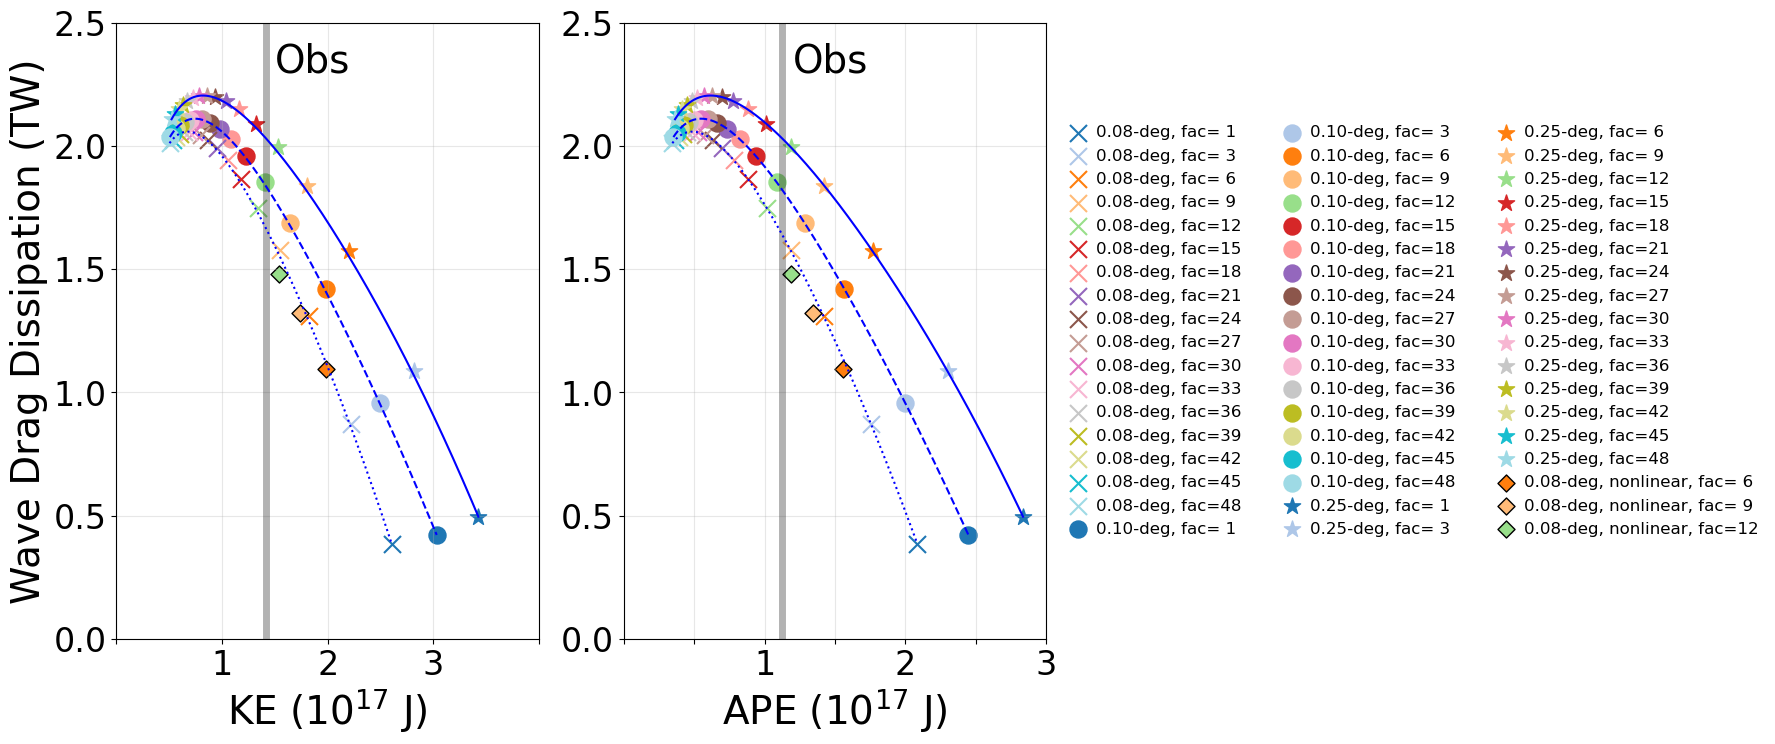

In [78]:
fig = plt.figure(figsize=(12, 8))
axs = []

gridsubs = gridspec.GridSpec(1,2)
for gs in gridsubs:
    axs.append(plt.subplot(gs))

# c_text = ['k','b','g','c','r','orange','m','purple']
colors = plt.cm.tab20(np.linspace(0, 1, 17))

def sort_interp(mKE, rmse, k=3):
    sorted_ind = np.argsort(mKE)
    mKE_sorted = mKE[sorted_ind]
    rmse_sorted = rmse[sorted_ind]
    
    mKE_smooth = np.linspace(mKE_sorted.min(), mKE_sorted.max(), 5000)  # Create a smooth x-axis
    spline = make_interp_spline(mKE_sorted, rmse_sorted, k=3)         # Cubic spline interpolation
    # spline = PchipInterpolator(mKE_sorted, rmse_sorted)         # Cubic spline interpolation
    rmse_smooth = spline(mKE_smooth)
    
    return mKE_smooth, rmse_smooth


ke_smooth_025, sigma_smooth_025 = sort_interp(mKE_025, sigma_025)
ke_smooth_01, sigma_smooth_01 = sort_interp(mKE_01, sigma_01,k=2)
ke_smooth_008, sigma_smooth_008 = sort_interp(mKE_008, sigma_008)

ape_smooth_025, sigma_smooth_025 = sort_interp(mAPE_025, sigma_025)
ape_smooth_01, sigma_smooth_01 = sort_interp(mAPE_01, sigma_01,k=2)
ape_smooth_008, sigma_smooth_008 = sort_interp(mAPE_008, sigma_008)

for I, ax in enumerate(axs):
    
    ax.set_ylim(0,2.5)
    ax.set_yticks(np.arange(0,2.5+0.5,0.5))
    ax.tick_params(labelsize=24)

    marker_size = 150
    if I==0:
        ax.set_xlim(0e+17,4e+17)
        ax.set_xticks(np.arange(0e+17,5e+17,1e+17))
        ax.set_xticklabels(['','1','2','3',''])
        ax.set_xlabel('KE (10$^{17}$ J)',fontsize=28)
        ax.set_ylabel('Wave Drag Dissipation (TW)',fontsize=28)
        ax.text(1.5e+17,2.3,'Obs',fontsize=28)
        ax.plot([mKE_TPXO,mKE_TPXO],[0,3],'k',linewidth=5,alpha=0.3)
        ax.plot(ke_smooth_025, sigma_smooth_025, color='b')
        ax.plot(ke_smooth_01, sigma_smooth_01, color='b',linestyle='--')
        ax.plot(ke_smooth_008, sigma_smooth_008, color='b',linestyle=':')

        for i in range(17):
            ax.scatter(mKE_025[i],sigma_025[i],s=marker_size,c=colors[i],marker='*',edgecolor=colors[i])
            ax.scatter(mKE_01[i],sigma_01[i],s=marker_size,c=colors[i],marker='o',edgecolor=colors[i])
            ax.scatter(mKE_008[i],sigma_008[i],s=marker_size,c=colors[i],marker='x',edgecolor=colors[i])
        for i in range(3):
            ax.scatter(mKE_008_non[i],sigma_008_non[i],s=marker_size/2,c=colors[i+2],marker='D',edgecolor='k')
        ax.grid(True,alpha=0.3)

    if I==1:
        ax.set_xlim(0e+17,3e+17)
        ax.set_xticks(np.arange(0e+17,3.5e+17,0.5e+17))
        ax.set_xticklabels(['','','1','','2','','3'])
        ax.set_xlabel('APE (10$^{17}$ J)',fontsize=28)
        ax.text(1.2e+17,2.3,'Obs',fontsize=28)
        ax.plot([mAPE_TPXO,mAPE_TPXO],[0,3],'k',linewidth=5,alpha=0.3)
        ax.plot(ape_smooth_025, sigma_smooth_025, color='b')
        ax.plot(ape_smooth_01, sigma_smooth_01, color='b',linestyle='--')
        ax.plot(ape_smooth_008, sigma_smooth_008, color='b',linestyle=':')
        
        for i in range(17):
            ax.scatter(mAPE_008[i],sigma_008[i],s=marker_size,c=colors[i],marker='x',edgecolor=colors[i],label='0.08-deg, fac=%2d'%fac[i])
        for i in range(17):
            ax.scatter(mAPE_01[i],sigma_01[i],s=marker_size,c=colors[i],marker='o',edgecolor=colors[i],label='0.10-deg, fac=%2d'%fac[i])
        for i in range(17):
            ax.scatter(mAPE_025[i],sigma_025[i],s=marker_size,c=colors[i],marker='*',edgecolor=colors[i],label='0.25-deg, fac=%2d'%fac[i])
        for i in range(3):
            ax.scatter(mAPE_008_non[i],sigma_008_non[i],s=marker_size/2,c=colors[i+2],marker='D',edgecolor='k',label='0.08-deg, nonlinear, fac=%2d'%((i+2)*3))
        ax.grid(True,alpha=0.3)

        ax.legend(loc='center left',bbox_to_anchor=(1,0.5),fontsize=12,ncol=3,handletextpad=0.1,frameon=False)

plt.savefig('/g/data/nm03/lxy581/evaluate/tuning/SAL_SAH_masked_TPXO_M2_008_01_025_KE_APE_dissip_sigma.png', dpi=600, bbox_inches='tight')

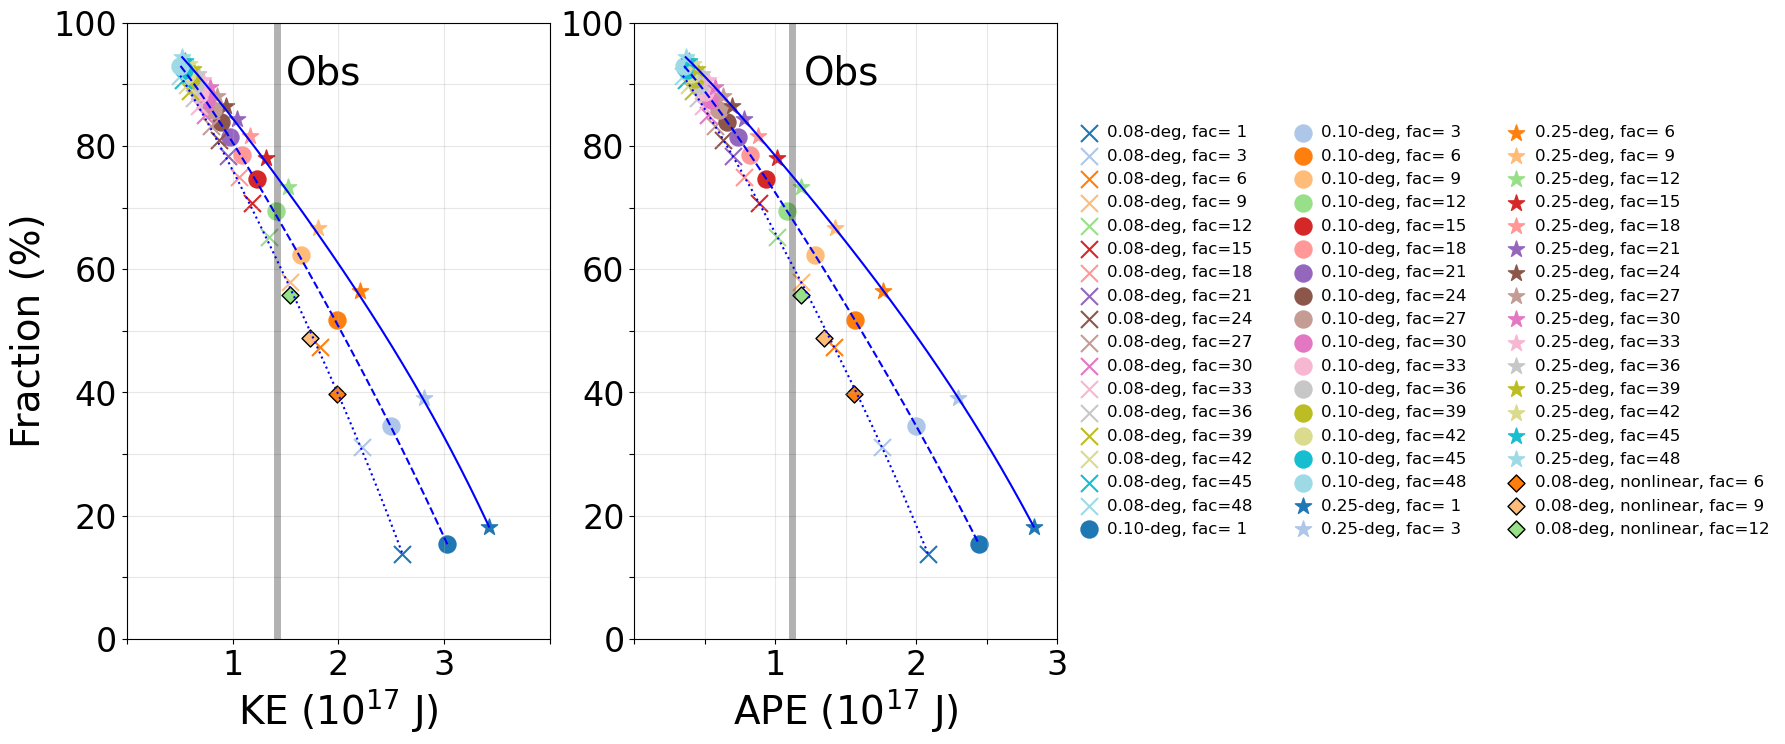

In [79]:
fig = plt.figure(figsize=(12, 8))
axs = []

gridsubs = gridspec.GridSpec(1,2)
for gs in gridsubs:
    axs.append(plt.subplot(gs))

# c_text = ['k','b','g','c','r','orange','m','purple']
colors = plt.cm.tab20(np.linspace(0, 1, 17))

ke_smooth_025, perc_smooth_025 = sort_interp(mKE_025, perc_025)
ke_smooth_01, perc_smooth_01 = sort_interp(mKE_01, perc_01)
ke_smooth_008, perc_smooth_008 = sort_interp(mKE_008, perc_008)

ape_smooth_025, perc_smooth_025 = sort_interp(mAPE_025, perc_025)
ape_smooth_01, perc_smooth_01 = sort_interp(mAPE_01, perc_01)
ape_smooth_008, perc_smooth_008 = sort_interp(mAPE_008, perc_008)

for I, ax in enumerate(axs):
    
    ax.set_ylim(0,1.0)
    ax.set_yticks(np.arange(0,1.0+0.1,0.1))
    ax.set_yticklabels(['0','','20','','40','','60','','80','','100'])
    ax.tick_params(labelsize=24)

    marker_size = 150
    if I==0:
        ax.set_xlim(0e+17,4e+17)
        ax.set_xticks(np.arange(0e+17,5e+17,1e+17))
        ax.set_xticklabels(['','1','2','3',''])
        ax.set_xlabel('KE (10$^{17}$ J)',fontsize=28)
        ax.set_ylabel('Fraction (%)',fontsize=28)
        ax.text(1.5e+17,0.9,'Obs',fontsize=28)
        ax.plot([mKE_TPXO,mKE_TPXO],[0,1.0],'k',linewidth=5,alpha=0.3)
        ax.plot(ke_smooth_025, perc_smooth_025, color='b')
        ax.plot(ke_smooth_01, perc_smooth_01, color='b',linestyle='--')
        ax.plot(ke_smooth_008, perc_smooth_008, color='b',linestyle=':')

        for i in range(17):
            ax.scatter(mKE_025[i],perc_025[i],s=marker_size,c=colors[i],marker='*',edgecolor=colors[i])
            ax.scatter(mKE_01[i],perc_01[i],s=marker_size,c=colors[i],marker='o',edgecolor=colors[i])
            ax.scatter(mKE_008[i],perc_008[i],s=marker_size,c=colors[i],marker='x',edgecolor=colors[i])
        for i in range(3):
            ax.scatter(mKE_008_non[i],perc_008_non[i],s=marker_size/2,c=colors[i+2],marker='D',edgecolor='k')
        ax.grid(True,alpha=0.3)

    if I==1:
        ax.set_xlim(0e+17,3e+17)
        ax.set_xticks(np.arange(0e+17,3.5e+17,0.5e+17))
        ax.set_xticklabels(['','','1','','2','','3'])
        ax.set_xlabel('APE (10$^{17}$ J)',fontsize=28)
        ax.text(1.2e+17,0.9,'Obs',fontsize=28)
        ax.plot([mAPE_TPXO,mAPE_TPXO],[0,1.0],'k',linewidth=5,alpha=0.3)
        ax.plot(ape_smooth_025, perc_smooth_025, color='b')
        ax.plot(ape_smooth_01, perc_smooth_01, color='b',linestyle='--')
        ax.plot(ape_smooth_008, perc_smooth_008, color='b',linestyle=':')

        for i in range(17):
            ax.scatter(mAPE_008[i],perc_008[i],s=marker_size,c=colors[i],marker='x',edgecolor=colors[i],label='0.08-deg, fac=%2d'%fac[i])
        for i in range(17):
            ax.scatter(mAPE_01[i],perc_01[i],s=marker_size,c=colors[i],marker='o',edgecolor=colors[i],label='0.10-deg, fac=%2d'%fac[i])
        for i in range(17):
            ax.scatter(mAPE_025[i],perc_025[i],s=marker_size,c=colors[i],marker='*',edgecolor=colors[i],label='0.25-deg, fac=%2d'%fac[i])
        for i in range(3):
            ax.scatter(mAPE_008_non[i],perc_008_non[i],s=marker_size/2,c=colors[i+2],marker='D',edgecolor='k',label='0.08-deg, nonlinear, fac=%2d'%((i+2)*3))
        ax.grid(True,alpha=0.3)

        ax.legend(loc='center left',bbox_to_anchor=(1,0.5),fontsize=12,ncol=3,handletextpad=0.1,frameon=False)

plt.savefig('/g/data/nm03/lxy581/evaluate/tuning/SAL_SAH_masked_TPXO_M2_008_01_025_KE_APE_perc.png', dpi=600, bbox_inches='tight')

In [35]:
perc_025

array([0.18212299, 0.3911876 , 0.56480377, 0.66679321, 0.73378146,
       0.78103691, 0.81607105, 0.84299622, 0.86425455, 0.88139517,
       0.89545028, 0.9071365 , 0.91696737, 0.92531959, 0.93247612,
       0.9386537 , 0.94402122])

In [36]:
perc_008

array([0.13834253, 0.31155019, 0.47329279, 0.57838517, 0.65256414,
       0.70760032, 0.7498786 , 0.78321239, 0.81003141, 0.83196005,
       0.85013548, 0.86537247, 0.87827102, 0.88928303, 0.89875546,
       0.90695787, 0.91410352])

In [37]:
perc_01

array([0.15333519, 0.34610532, 0.51728906, 0.62260271, 0.69404414,
       0.74617839, 0.78503956, 0.81525429, 0.83928764, 0.85873705,
       0.87470938, 0.88799365, 0.89916156, 0.90863838, 0.91674567,
       0.92373193, 0.92979218])